# FFS

## Step 0. Import Packages & Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# mount gdrive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
# change root to the necessary path
root = "/gdrive/MyDrive/ads_proj4/ads-spring-2022-prj4-group-11-1/"
outputs_dir = root + "output/"
lib_dir = root + "lib/"

assert os.path.exists(root), 'Check the path to your root directory'
assert os.path.exists(outputs_dir), 'Check the path to your outputs directory'
assert os.path.exists(lib_dir), 'Check the path to your lib directory'

sys.path.append(lib_dir)

## Step 1. Data Processing

In [ ]:
# loading data
compas = pd.read_csv(outputs_dir + 'ffs_data_v3.csv', header=0,
                     dtype = {'age_cat': int,'race': int,
                              'priors_count': int,'length_of_stay': int})
compas.head()

,age,c_charge_degree,race,sex,priors_count,length_of_stay,two_year_recid,juv_fel_count,juv_misd_count,juv_other_count
0,34,F,0,Male,0,1,1,0,0,0
1,24,F,0,Male,2,0,1,0,0,1
2,41,F,1,Male,2,0,1,0,0,0
3,39,M,1,Female,0,0,0,0,0,0
4,27,F,1,Male,0,0,0,0,0,0


In [ ]:
compas['c_charge_degree'] = pd.get_dummies(compas['c_charge_degree'])['F'] # 1 if felony, 0 if misdemeanor
compas['sex'] = pd.get_dummies(compas['sex'])['Male'] # 1 if male, 0 if female

juv_cond = (compas['juv_fel_count'] > 0) | (compas['juv_misd_count'] > 0) | (compas['juv_other_count'] > 0)
compas['has_juv'] = np.where(juv_cond, 1, 0)
compas['has_prior'] = np.where(compas['priors_count'] > 0, 1, 0)
compas.head()

,age,c_charge_degree,race,sex,priors_count,length_of_stay,two_year_recid,juv_fel_count,juv_misd_count,juv_other_count,has_juv,has_prior
0,34,1,0,1,0,1,1,0,0,0,0,0
1,24,1,0,1,2,0,1,0,0,1,1,1
2,41,1,1,1,2,0,1,0,0,0,0,1
3,39,0,1,0,0,0,0,0,0,0,0,0
4,27,1,1,1,0,0,0,0,0,0,0,0


In [ ]:
X = compas[['age', 'c_charge_degree', 'sex', 'length_of_stay', 
            'has_juv', 'has_prior']]
y = compas['two_year_recid']
protected = compas['race']

## Step 2. FFS: Computing Accuracy and Discrimination Shapley scores

Please run `run_ffs.py` to get the shapley scores for the features.

In [6]:
scores = pd.read_csv(outputs_dir + 'ffs_scores.csv', header=0)
scores

,Feature,Accuracy,Discrimination
0,age,2.972540,6.033005e+06
1,c_charge_degree,0.675193,3.177313e+06
2,sex,0.569750,2.770908e+06
3,length_of_stay,0.634509,3.482324e+06
4,has_juv,0.533954,1.609420e+06
5,has_prior,0.591429,2.751210e+06


In [21]:
scores.loc[0]['Accuracy']

2.972539554542558

Text(0, 0.5, 'Fairness Utility')

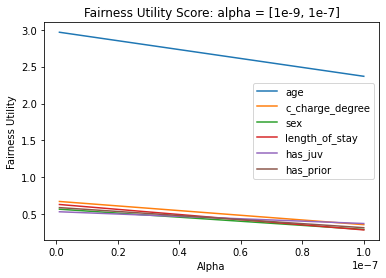

In [30]:
# fairness utility score
alpha = np.linspace(1e-7, 1e-9, 10000)
def utility(acc, disc, alpha):
  return acc - (alpha * disc)

for i in range(len(scores)):
  plt.plot(alpha, utility(scores.loc[i]['Accuracy'], 
                          scores.loc[i]['Discrimination'],
                          alpha), label=scores.loc[i]['Feature'])
  
plt.legend()
plt.title("Fairness Utility Score: alpha = [1e-9, 1e-7]")
plt.xlabel('Alpha')
plt.ylabel('Fairness Utility')

In [5]:
scores["rel_acc"] = scores['Accuracy'] / np.sum(scores['Accuracy']) * 100
scores['rel_disc'] = scores['Discrimination'] / np.sum(scores['Discrimination']) * 100
scores

,Feature,Accuracy,Discrimination,rel_acc,rel_disc
0,age,2.972540,6.033005e+06,49.729851,30.432558
1,c_charge_degree,0.675193,3.177313e+06,11.295816,16.027462
2,sex,0.569750,2.770908e+06,9.531777,13.977417
3,length_of_stay,0.634509,3.482324e+06,10.615180,17.566042
4,has_juv,0.533954,1.609420e+06,8.932920,8.118469
5,has_prior,0.591429,2.751210e+06,9.894455,13.878052


Text(0, 0.5, 'Shapley Accuracy')

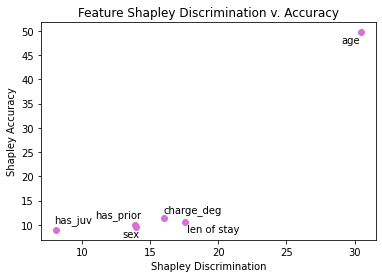

In [ ]:
plt.scatter(scores['rel_disc'], scores['rel_acc'], color='orchid')
plt.annotate('has_juv', (8, 10.5))
plt.annotate('has_prior', (11, 11.5))
plt.annotate('sex', (13, 7.5))
plt.annotate('charge_deg', (16, 12.5))
plt.annotate('len of stay', (17.7, 8.5))
plt.annotate('age', (29, 47.5))
plt.title('Feature Shapley Discrimination v. Accuracy')
plt.xlabel('Shapley Discrimination')
plt.ylabel('Shapley Accuracy')

## Step 3. Experiments

In [ ]:
def FPR(fp, tn):
  return fp / (fp + tn)

def calibration(tn, fp, fn, tp):
  return (tn+tp) / (tn+fp+fn+tp)

def bias_exp(X, y, protected, exp_num=5):
  full = X.assign(race = protected)
  FPR_black = []
  FPR_white = []
  cal_black = []
  cal_white = []

  for i in range(exp_num):

    X_train, X_test, y_train, y_test = train_test_split(full, y, test_size=0.2, random_state=i*5)
    X_train = X_train.drop('race', axis=1)
    model = GradientBoostingClassifier(n_estimators=80, learning_rate=0.25, max_depth=1, max_features=5, random_state=0)
    model.fit(X_train, y_train)

    data = X_test.assign(two_year_recid = y_test)
    data_black = data[data['race']==0]
    data_white = data[data['race']==1]

    y_pred_black = model.predict(data_black.drop(['race', 'two_year_recid'], axis=1))
    y_pred_white = model.predict(data_white.drop(['race', 'two_year_recid'], axis=1))

    # black
    tn, fp, fn, tp = confusion_matrix(data_black['two_year_recid'], 
                                      y_pred_black).ravel()
    black_fpr = FPR(fp, tn)
    FPR_black.append(black_fpr)
    black_cal = calibration(tn, fp, fn, tp)
    cal_black.append(black_cal)
    # white
    tn, fp, fn, tp = confusion_matrix(data_white['two_year_recid'], 
                                      y_pred_white).ravel()
    white_fpr = FPR(fp, tn)
    FPR_white.append(white_fpr)
    white_cal = calibration(tn, fp, fn, tp)
    cal_white.append(white_cal)

  return cal_black, cal_white, FPR_black, FPR_white

In [ ]:
model = GradientBoostingClassifier(n_estimators=80, learning_rate=0.25, max_depth=1, max_features=5, random_state=0)
exp_df = pd.DataFrame(columns=['Experiment', 'Accuracy (mean)', 'Accuracy (std)', 
                               'Black Cal', 'White Cal', 'Black FPR', 'White FPR'])

# all features first
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=5, n_jobs=-1, error_score='raise')
black_cal, white_cal, black_fpr, white_fpr = bias_exp(X, y, protected)
exp_df.loc[len(exp_df.index)] = ["none", np.mean(n_scores), np.std(n_scores),
                                 np.mean(black_cal), np.mean(white_cal),
                                 np.mean(black_fpr), np.mean(white_fpr)]

# drop one feature
for feat in X.columns:
  X_drop = X.drop(feat, axis=1)
  n_scores = cross_val_score(model, X_drop, y, scoring='accuracy', cv=5, n_jobs=-1, error_score='raise')
  black_cal, white_cal, black_fpr, white_fpr = bias_exp(X_drop, y, protected)
  exp_df.loc[len(exp_df.index)] = [feat, np.mean(n_scores), np.std(n_scores),
                                   np.mean(black_cal), np.mean(white_cal),
                                  np.mean(black_fpr), np.mean(white_fpr)]

exp_df

,Experiment,Accuracy (mean),Accuracy (std),Black Cal,White Cal,Black FPR,White FPR
0,none,0.655360,0.010137,0.670557,0.652635,0.365808,0.240324
1,age,0.626755,0.011313,0.638697,0.624805,0.402500,0.334524
2,c_charge_degree,0.655359,0.011145,0.673453,0.654490,0.343827,0.235020
3,sex,0.650626,0.012602,0.663799,0.653122,0.378425,0.252826
4,length_of_stay,0.643991,0.011733,0.661915,0.641100,0.356136,0.224992
5,has_juv,0.647781,0.013336,0.660886,0.647391,0.370419,0.252574
6,has_prior,0.620118,0.010259,0.633454,0.637007,0.329997,0.240527


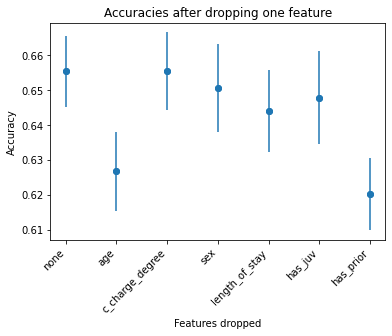

In [ ]:
plt.scatter(exp_df['Experiment'], exp_df['Accuracy (mean)']) 
plt.errorbar(exp_df['Experiment'], exp_df['Accuracy (mean)'], yerr=exp_df['Accuracy (std)'], fmt="o")

plt.title('Accuracies after dropping one feature')
plt.ylabel('Accuracy')
plt.xlabel('Features dropped')
plt.xticks(rotation=45, ha="right")
plt.show()

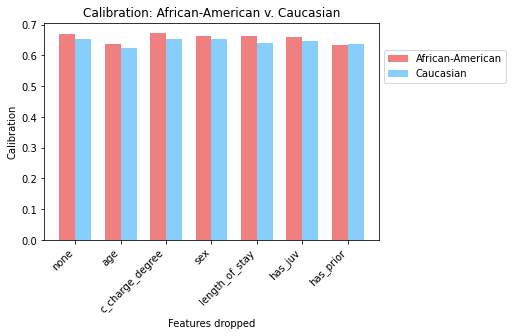

In [ ]:
# calibration

labels = list(exp_df['Experiment'])
x = np.arange(len(exp_df['Experiment']))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, exp_df['Black Cal'], width, label='African-American', color='lightcoral')
rects2 = ax.bar(x + width/2, exp_df['White Cal'], width, label='Caucasian', color='lightskyblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Calibration')
ax.set_xlabel('Features dropped')
ax.set_title('Calibration: African-American v. Caucasian')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))

#fig.tight_layout()

plt.show()

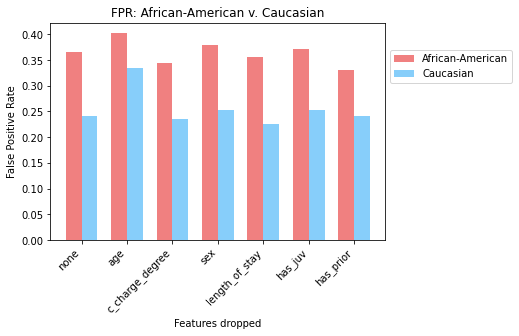

In [ ]:
# FPR

labels = list(exp_df['Experiment'])
x = np.arange(len(exp_df['Experiment']))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, exp_df['Black FPR'], width, label='African-American', color='lightcoral')
rects2 = ax.bar(x + width/2, exp_df['White FPR'], width, label='Caucasian', color='lightskyblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('False Positive Rate')
ax.set_xlabel('Features dropped')
ax.set_title('FPR: African-American v. Caucasian')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))

#fig.tight_layout()

plt.show()

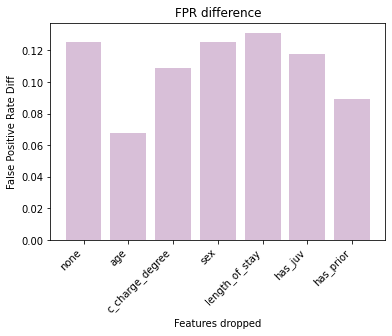

In [ ]:
plt.bar(exp_df['Experiment'], exp_df['Black FPR'] - exp_df['White FPR'], color='thistle')
plt.title('FPR difference')
plt.xlabel('Features dropped')
plt.ylabel('False Positive Rate Diff')
plt.xticks(rotation=45, ha="right")
plt.show()

## Step 4. Including race as a feature for benchmarking

In [ ]:
X = compas[['age', 'c_charge_degree', 'sex', 'race', 'length_of_stay', 
            'has_juv', 'has_prior']]
y = compas['two_year_recid']

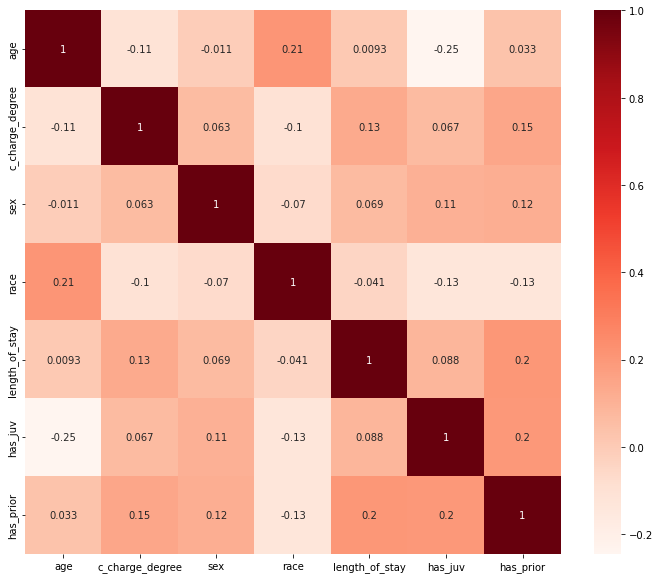

In [ ]:
# feature correlation
plt.figure(figsize=(12,10))
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
model = GradientBoostingClassifier(n_estimators=80, learning_rate=0.25, max_depth=1, max_features=5, random_state=0)

# all features first
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=5, n_jobs=-1, error_score='raise')
print("Accuracy:", np.mean(n_scores))
print("Std:", np.std(n_scores))

Accuracy: 0.656496301881373
Std: 0.013633703748875965


In [ ]:
FPR_black = []
FPR_white = []
cal_black = []
cal_white = []

for i in range(5):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i*5)
  model = GradientBoostingClassifier(n_estimators=80, learning_rate=0.25, max_depth=1, max_features=5, random_state=0)
  model.fit(X_train, y_train)

  data = X_test.assign(two_year_recid = y_test)
  data_black = data[data['race']==0]
  data_white = data[data['race']==1]

  y_pred_black = model.predict(data_black.drop(['two_year_recid'], axis=1))
  y_pred_white = model.predict(data_white.drop(['two_year_recid'], axis=1))

  # black
  tn, fp, fn, tp = confusion_matrix(data_black['two_year_recid'], 
                                    y_pred_black).ravel()
  black_fpr = FPR(fp, tn)
  FPR_black.append(black_fpr)
  black_cal = calibration(tn, fp, fn, tp)
  cal_black.append(black_cal)

  # white
  tn, fp, fn, tp = confusion_matrix(data_white['two_year_recid'], 
                                    y_pred_white).ravel()
  white_fpr = FPR(fp, tn)
  FPR_white.append(white_fpr)
  white_cal = calibration(tn, fp, fn, tp)
  cal_white.append(white_cal)

print("Black cal:", np.mean(cal_black))
print("White cal:", np.mean(cal_white))
print("Black FPR:", np.mean(FPR_black))
print("White FPR:", np.mean(FPR_white))

Black cal: 0.6687421995868552
White cal: 0.6643325693957113
Black FPR: 0.3967150351876634
White FPR: 0.18507672266766134
